In [1]:
import sys
sys.path.extend(['..', '../bprime'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import json
import time
import pickle
from multiprocessing import Pool
import itertools

import numpy as np
import scipy.stats as stats
import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd
import statsmodels.api as sm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from bprime.utils import index_cols
from bprime.sim_utils import read_params, get_bounds
from bprime.plots import surface_plot
from bprime.learn import LearnedFunction
from bprime.theory import bgs_segment, bgs_rec

os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [3]:
lowess = sm.nonparametric.lowess

In [4]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')


In [5]:
def log_tick_formatter(val, pos=None):
    return f"$10^{{{np.round(val, 1)}}}$"

## Data

In [6]:
with open('../slim_sims/training/fullbgs_dist.json') as f:
    sim_config = json.load(f)
sim_params, sim_param_types = read_params(sim_config)
sim_bounds = get_bounds(sim_params)
sim_bounds

{'N': (1000, 1000, False),
 'mu': (1e-10, 1e-07, False),
 's': (-5, -1, True),
 'h': (0.5, 0.5, False),
 'rf': (0, 0.5, False),
 'rbp': (-12, -6, True),
 'L': (1, 1101, False)}

In [7]:
sim_data = np.load('../data/slim_sims/fullbgs_dist_data.npz', allow_pickle=True)

In [8]:
Xcols = index_cols(sim_data['features'])
ycols = index_cols(sim_data['targets'])
sim_data['features'], sim_data['targets']

(array(['N', 'sh', 'mu', 'rf', 'rbp', 'L'], dtype='<U3'),
 array(['pi', 'Bhat', 'Ef', 'Vf', 'load'], dtype='<U4'))

In [9]:
assert len(sim_data['features']) == sim_data['X'].shape[1]

In [10]:
Xo, yo = np.array(sim_data['X']), sim_data['y']
Xo.shape, yo.shape

((100000, 6), (100000, 5))

In [11]:
# make sure we only have one population size
assert len(np.unique(Xo[:, Xcols('N')])) == 1

To be aligned with classic BGS theory, let's parameterize the heterozygous effect as $sh$. We build up our training dataset:

In [12]:
X_columns = ('sh', 'mu', 'rf', 'rbp', 'L')
X = Xo[:, Xcols(*X_columns)]
X, X.shape

(array([[1.5260e-04, 1.8560e-08, 2.1290e-01, 5.2480e-09, 2.7700e+02],
        [1.5975e-05, 8.0900e-09, 2.1840e-01, 2.3990e-10, 8.4300e+02],
        [9.7550e-06, 5.5990e-10, 1.2450e-01, 6.1220e-09, 9.8300e+02],
        ...,
        [4.9905e-05, 7.7510e-08, 4.6560e-01, 5.1940e-11, 5.1500e+02],
        [4.7825e-04, 3.1050e-08, 2.6810e-01, 1.8870e-08, 5.4900e+02],
        [1.0280e-05, 2.6050e-08, 1.0490e-01, 3.4600e-08, 1.0880e+03]]),
 (100000, 5))

Now extract the target, $\hat{B}$.

In [29]:
y = np.log10(yo[:, ycols('Bhat')])

Use the `LearnedFunction` class to store data, etc.

In [30]:
# h is fixed
assert sim_bounds['h'][0] == sim_bounds['h'][1]
h = sim_bounds['h'][0]

# rescale s bounds since we model sh
sh_domain = lambda l, u, _, h: (np.round(np.log10((10**l)*h), 3), np.round(np.log10((10**u)*h), 3), True)

domain = {'sh': sh_domain(*sim_bounds['s'], h)}
domain = {**domain, **{k: v for k, v in sim_bounds.items() if k in X_columns}}


func = LearnedFunction(X, y, domain=domain)
func

LearnedFunction with 5 feature(s) and 1 target(s)
 feature(s):
  - sh ∈ [-5.3, -1.3] (log10, None)
  - mu ∈ [1e-10, 1e-07] (linear, None)
  - rf ∈ [0.0, 0.5] (linear, None)
  - rbp ∈ [-12, -6] (log10, None)
  - L ∈ [1, 1100] (linear, None)
Features normalized? False
Features split? False

In [31]:
func.bounds

{'sh': (-5.301, -1.301),
 'mu': (1e-10, 1e-07),
 'rf': (0, 0.5),
 'rbp': (-12, -6),
 'L': (1, 1101)}

In [32]:
func.split()

LearnedFunction with 5 feature(s) and 1 target(s)
 feature(s):
  - sh ∈ [-5.3, -1.3] (log10, None)
  - mu ∈ [1e-10, 1e-07] (linear, None)
  - rf ∈ [0.0, 0.5] (linear, None)
  - rbp ∈ [-12, -6] (log10, None)
  - L ∈ [1, 1100] (linear, None)
Features normalized? False
Features split? True, test size: 20.0% (n=20,000)

In [33]:
func.X_train.shape

(80000, 5)

In [34]:
#feature_transforms = {'mu': np.log10, 's': np.log10, 'recfrac': np.log10}
feature_transforms = {'mu': None, 'sh': np.log10, 'rf': np.log10}
feature_transforms = 'match'
func.scale_features(transforms = feature_transforms)

LearnedFunction with 5 feature(s) and 1 target(s)
 feature(s):
  - sh ∈ [-5.3, -1.3] (log10, <ufunc 'log10'>)
  - mu ∈ [1e-10, 1e-07] (linear, None)
  - rf ∈ [0.0, 0.5] (linear, None)
  - rbp ∈ [-12, -6] (log10, <ufunc 'log10'>)
  - L ∈ [1, 1100] (linear, None)
Features normalized? True
Features split? True, test size: 20.0% (n=20,000)

In [37]:
def network(n64=4, n32=2, output_activation='relu'):
    # build network
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(5,)))
    for i in range(n64):
        model.add(layers.Dense(64, activation='elu'))
    for i in range(n32):
        model.add(layers.Dense(32, activation='elu'))
    model.add(tf.keras.layers.Dense(1, activation=output_activation))
    model.compile(
        optimizer='Adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['MeanAbsoluteError'],
        )
    return model

In [38]:
force = True
model_file = '../data/dnn_models/fullbgs.h5'
history_file = '../data/dnn_models/fullbgs_keras_history.pkl'
if force or not os.path.exists(model_file):
    model = network(n64=4, n32=4, output_activation='sigmoid')
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                       patience=50, restore_best_weights=True)
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

    history = model.fit(func.X_train, func.y_train, 
                        validation_split=0.3, 
                        #validation_data=(X_test_normalized, y_test),
                        batch_size=64, epochs=200, verbose=0, callbacks=[es, tqdm_callback])
    model.save(model_file)
    with open(history_file, 'wb') as f:
        pickle.dump(history, f)
else:
    model = keras.models.load_model(model_file)
    with open(history_file, 'rb') as f:
        history = pickle.load(f)

Training:   0%|                                                                                               …

Restoring model weights from the end of the best epoch: 14.
Epoch 00064: early stopping
INFO:tensorflow:Assets written to: ram://8a918a5d-47e8-45ad-b98c-da79b8769926/assets


In [39]:
func.model = model
#func.save('../data/dnn_models/fullbgs')

In [40]:
func.predict

<bound method LearnedFunction.predict of LearnedFunction with 5 feature(s) and 1 target(s)
 feature(s):
  - sh ∈ [-5.3, -1.3] (log10, <ufunc 'log10'>)
  - mu ∈ [1e-10, 1e-07] (linear, None)
  - rf ∈ [0.0, 0.5] (linear, None)
  - rbp ∈ [-12, -6] (log10, <ufunc 'log10'>)
  - L ∈ [1, 1100] (linear, None)
Features normalized? True
Features split? True, test size: 20.0% (n=20,000)>

In [41]:
predict = func.predict_test(verbose=1)
np.mean((predict - func.y_test)**2)

625/625 [==============================] - 1s 1ms/step


0.03600633642440604

In [42]:
%%timeit
# how fast is prediction?
_ = func.predict_train(workers=70, use_multiprocessing=True)

2.77 s ± 61.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
idx = np.abs(predict - 1) < 0.1
((predict[idx] - func.y_test[idx])**2).mean()

/tmp/ipykernel_44983/2291778217.py:2: RuntimeWarning: Mean of empty slice.
  ((predict[idx] - func.y_test[idx])**2).mean()
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [44]:
predict.max()

1.0445767e-07

In [45]:
func.features

{'sh': 0, 'mu': 1, 'rf': 2, 'rbp': 3, 'L': 4}

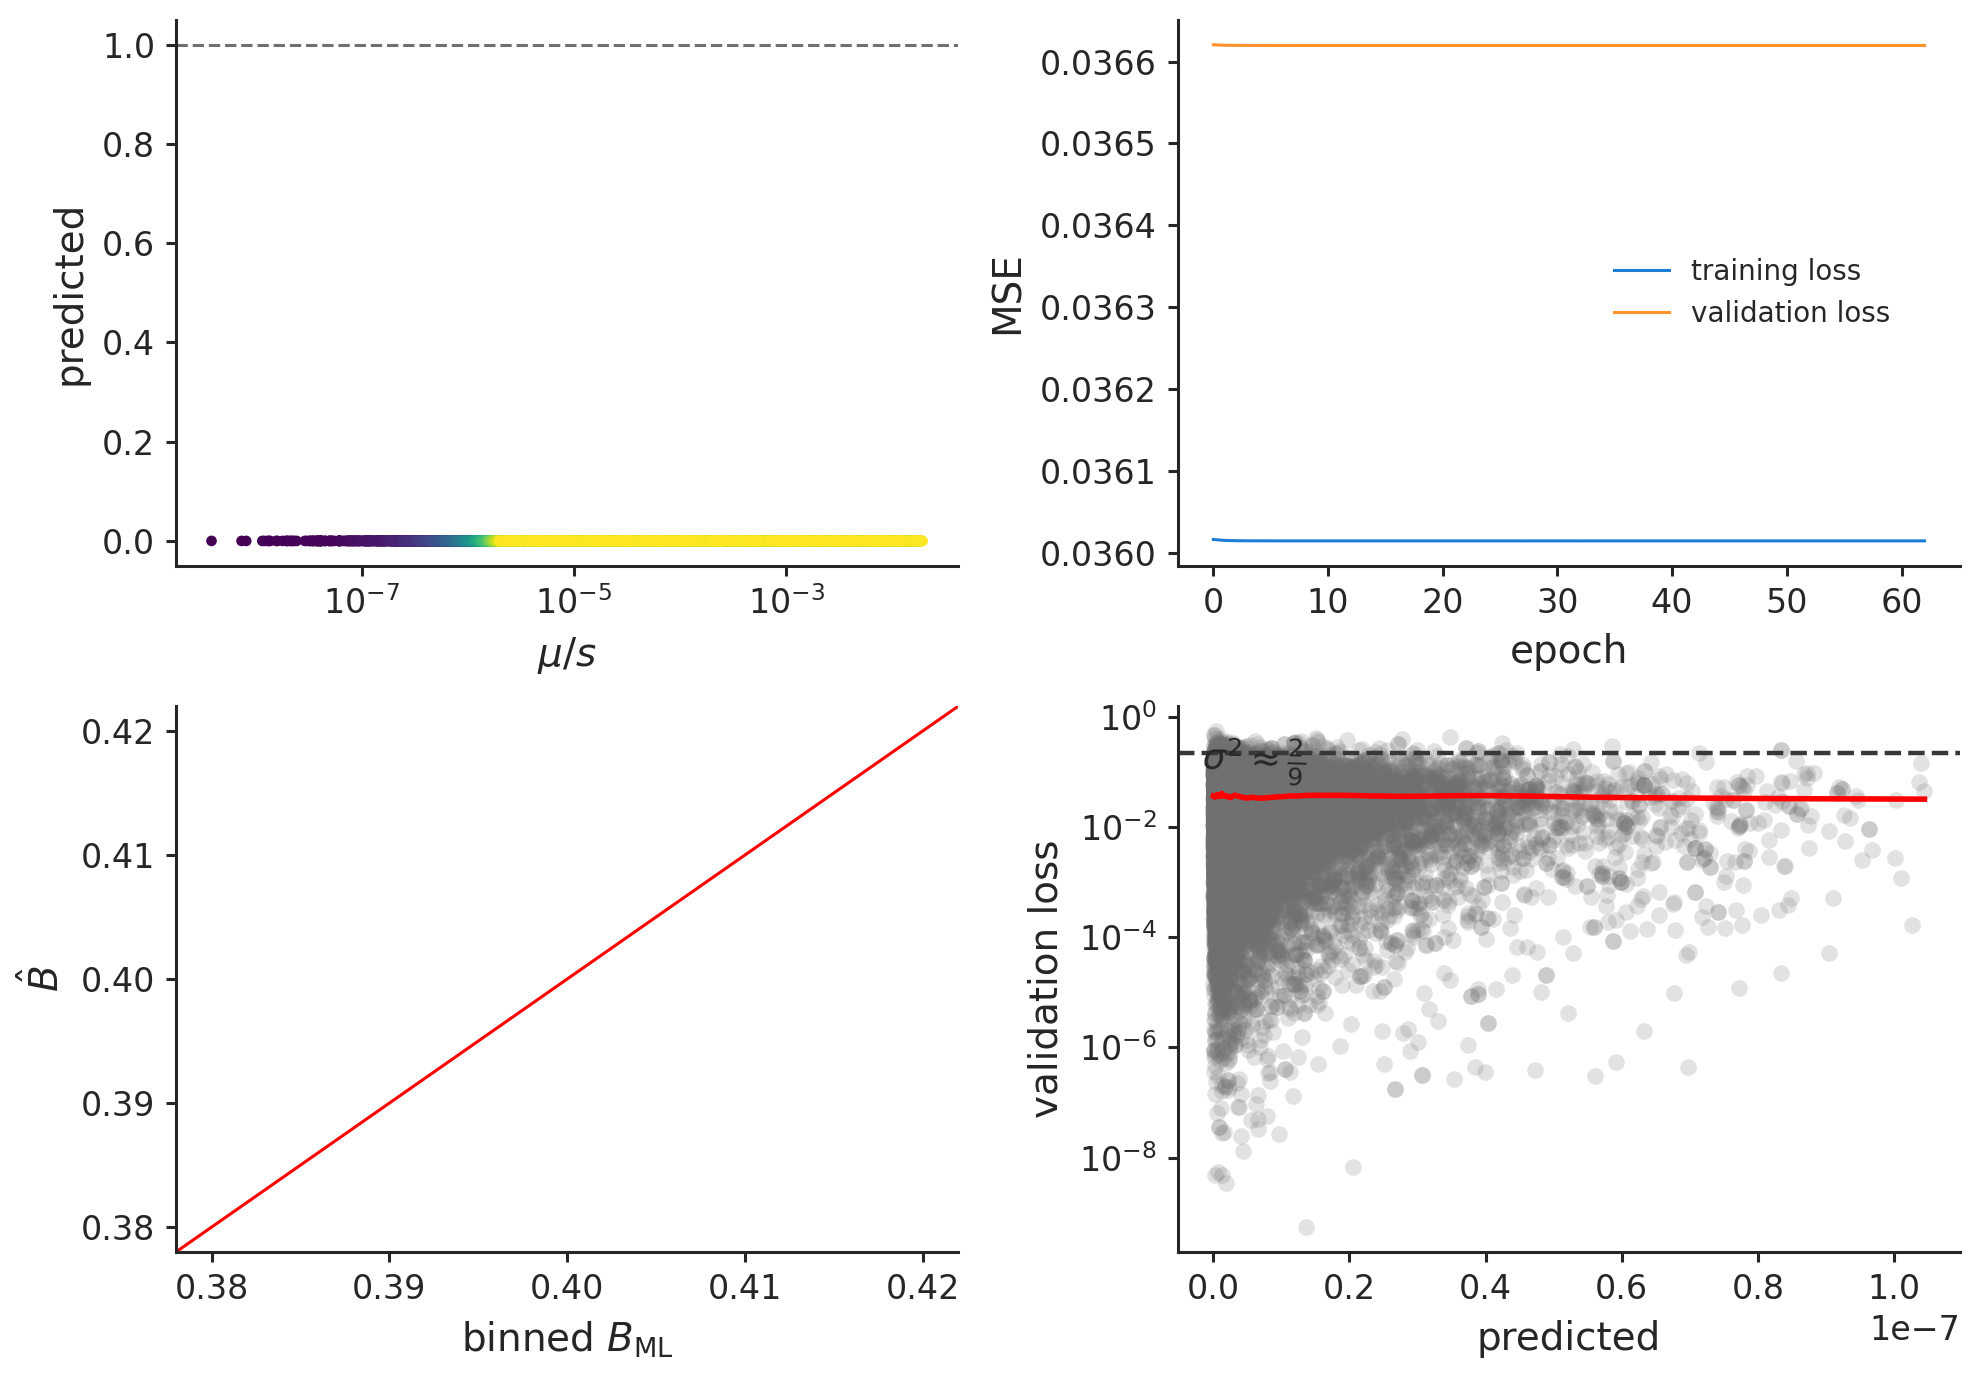

In [51]:
#y_theory = bgs_rec(func.X_test_orig[:, 0], func.X_test_orig[:, 1], func.X_test_orig[:, 2], 1000)

s_test, mu_test, rbp_test, rf_test, L_test = func.X_test_orig.T
rate = mu_test/10**s_test

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 7))

norm = plt.Normalize(np.min(mu_test), np.max(mu_test))

idx = np.argsort(mu_test)

ax1.scatter(rate[idx], predict[idx], c=mu_test[idx], cmap='viridis', s=8)
ax1.set_xlabel("$\mu/s$")
ax1.set_ylabel("predicted")
ax1.axhline(1, c='0.44', linestyle='dashed')
ax1.semilogx()
#cax1 = fig.add_axes([0.27, 0.8, 0.5, 0.05])
#fig.colorbar(cmap=cm.viridis, cax=cax1, orientation='horizontal')

#n = 10
#yedges = np.linspace(y_test.min(), y_test.max(), n)
#xedges = np.linspace(predict.min(), predict.max(), n)
#H, xedges, yedges = np.histogram2d(y_test.squeeze(), predict, bins=(xedges, yedges))
#X, Y = np.meshgrid(xedges, yedges)
#ax3.pcolormesh(X, Y, H)
#ax3.scatter(func.y_test, predict, c=func.X_test[:, 1], s=5)
#ax3.axline((0, 0), slope=1, c='r', linewidth=1, zorder=0)
#ax3.set_xlabel('y')
#ax3.set_ylabel('predicted')

bins = np.linspace(0.4, 1, 50)
ytest_bins = stats.binned_statistic(predict, func.y_test.squeeze(), bins=bins)
ax3.scatter(0.5*(bins[1:] + bins[:-1]), ytest_bins.statistic, c='0.22')
ax3.set_ylabel('$\hat{B}$')
ax3.set_xlabel('binned $B_\mathrm{ML}$')
ax3.axline((0.4, 0.4), slope=1, c='r')


ly = (predict - func.y_test.squeeze())**2
lX = predict
ax4.scatter(lX, ly, color='0.44', 
            linewidth=0, edgecolor='black', alpha=0.2)
#ax4.set_ylim(-0.1, 3)
z = lowess(ly, lX, frac= 1/10, it=0)
ax4.plot(z[:, 0], z[:, 1], c='r', linewidth=2)

# the lowess fit was sensitive to it=0; this shows that the it=0 
# case is nearly identical to OLS, e.g. right thing to do
#mod = sm.OLS(ly, sm.add_constant(lX))
#res = mod.fit()
#lX_new = sm.add_constant(np.linspace(0.4, 1, 100))
#ax4.plot(lX_new, res.predict(lX_new), c='g')

xnew = np.linspace(0.4, 1, 100)
def B_var_limit(B, N, mu=1):
    return (3*mu + 8*B*N*mu**2)/(36*B*N)
ax4.axhline(B_var_limit(1, 1000), c='0.22', linewidth=1.6, linestyle='dashed') # Note the 1/2 factor — see sim_power.ipynb! TODO
#ax4.text(0.03, 0.88, "$\sigma^2 = \\frac{3 \mu + 8 B N \mu}{36 B N}$", size=13, rotation=-1.5, transform=ax4.transAxes)
ax4.text(0.03, 0.88, "$\sigma^2 \\approx \\frac{2}{9}$", size=13, rotation=-1.5, transform=ax4.transAxes)
ax4.semilogy()
ax4.set_ylabel('validation loss')
ax4.set_xlabel('predicted')

ax2.plot(history.history['loss'][1:], label='training loss')
ax2.plot(history.history['val_loss'][1:], label='validation loss')
ax2.set_ylabel("MSE")
ax2.set_xlabel("epoch")
#ax2.set_ylim((0, 1))
ax2.legend()
plt.tight_layout()

In [ ]:
fig, ax  = plt.subplots(figsize=(4, 3))

ax.scatter(rate, predict, c=mu_test, cmap='viridis', s=8)
ax.set_xlabel("$\mu/s$")
ax.set_ylabel("predicted")
ax.semilogx()

plt.tight_layout()

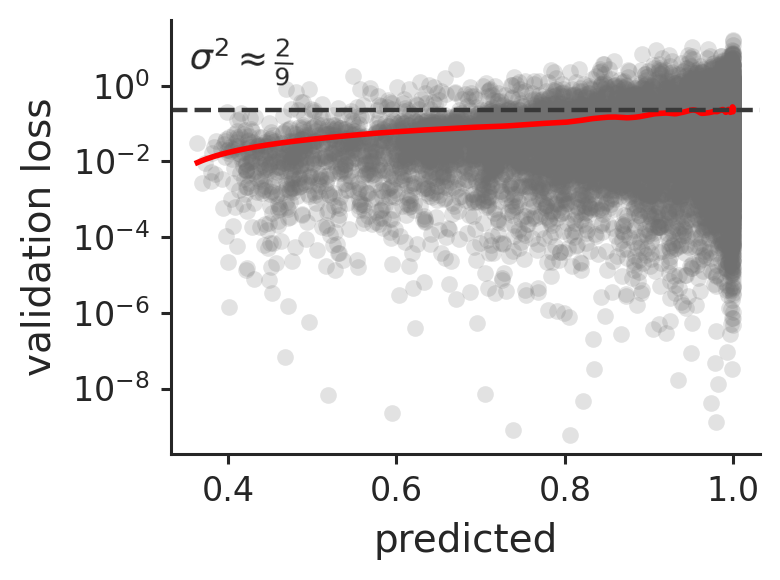

In [29]:
fig, ax  = plt.subplots(figsize=(4, 3))
ly = (predict - func.y_test.squeeze())**2
lX = predict
ax.scatter(lX, ly, color='0.44', 
            linewidth=0, edgecolor='black', alpha=0.2)
#ax4.set_ylim(-0.1, 3)
z = lowess(ly, lX, frac= 1/10, it=0)
ax.plot(z[:, 0], z[:, 1], c='r', linewidth=2)

ax.axhline(B_var_limit(1, 1000), c='0.22', linewidth=1.6, linestyle='dashed') # Note the 1/2 factor — see sim_power.ipynb! TODO
#ax4.text(0.03, 0.88, "$\sigma^2 = \\frac{3 \mu + 8 B N \mu}{36 B N}$", size=13, rotation=-1.5, transform=ax4.transAxes)
ax.text(0.03, 0.88, "$\sigma^2 \\approx \\frac{2}{9}$", size=13, rotation=-1.5, transform=ax.transAxes)
ax.semilogy()
ax.set_ylabel('validation loss')
ax.set_xlabel('predicted')
plt.tight_layout()

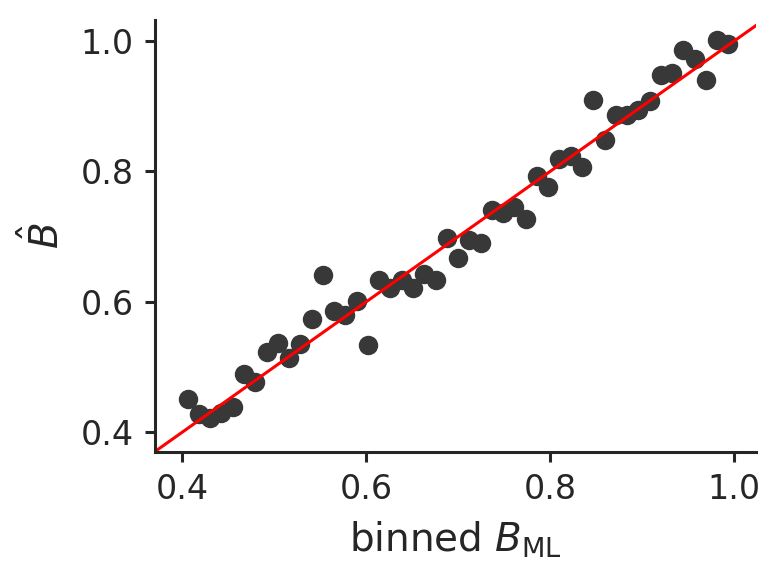

In [30]:
bins = np.linspace(0.4, 1, 50)
ytest_bins = stats.binned_statistic(predict, func.y_test.squeeze(), bins=bins)
fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(0.5*(bins[1:] + bins[:-1]), ytest_bins.statistic, c='0.22')
ax.set_ylabel('$\hat{B}$')
ax.set_xlabel('binned $B_\mathrm{ML}$')
ax.axline((0.4, 0.4), slope=1, c='r')
plt.tight_layout()


In [47]:
0.5*(1e-10 + 1e-5)

5.0000500000000005e-06

In [41]:
# Note that the training data does not log10 mu, but here we do (otherwise the grid looks
# like chunky peanut butter).
(s_grid, mu_grid, *_), X_mesh_orig, X_mesh, predict_grid = func.predict_grid({'mu': 101, 'sh': 100}, 
                                                                            fix_X={'rf': np.log10(1e-8),
                                                                                   'rbp': 1e-8,
                                                                                    'L': 1_000},
                                                                            log10=('mu', ))

making 101x100 grid...	done.
316/316 [==============================] - 1s 3ms/step


In [42]:
func.features

{'sh': 0, 'mu': 1, 'rf': 2, 'rbp': 3, 'L': 4}

In [43]:
X_mesh_orig

array([[-5.30100000e+00,  1.00000000e-10, -8.00000000e+00,
         1.00000000e-08,  1.00000000e+03],
       [-5.26059596e+00,  1.00000000e-10, -8.00000000e+00,
         1.00000000e-08,  1.00000000e+03],
       [-5.22019192e+00,  1.00000000e-10, -8.00000000e+00,
         1.00000000e-08,  1.00000000e+03],
       ...,
       [-1.38180808e+00,  1.00000000e-07, -8.00000000e+00,
         1.00000000e-08,  1.00000000e+03],
       [-1.34140404e+00,  1.00000000e-07, -8.00000000e+00,
         1.00000000e-08,  1.00000000e+03],
       [-1.30100000e+00,  1.00000000e-07, -8.00000000e+00,
         1.00000000e-08,  1.00000000e+03]])

In [44]:
ncontour = np.linspace(0.4, 0.96, 8)

Z = bgs_segment(X_mesh_orig[:, 1], 10**X_mesh_orig[:, 0], 10**X_mesh_orig[:, 2], X_mesh_orig[:, 3],  X_mesh_orig[:, 4]).reshape(predict_grid.shape).squeeze()
Zp = predict_grid.squeeze()

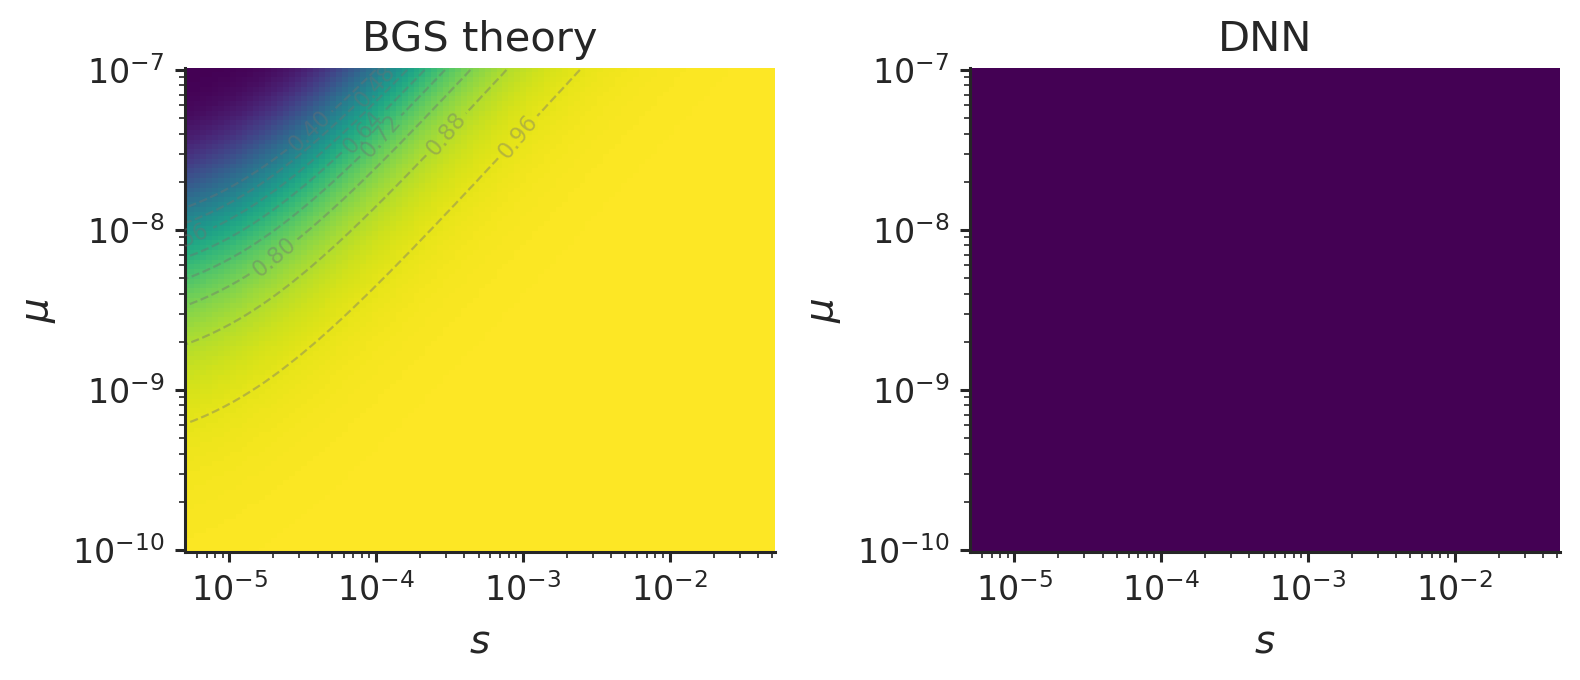

In [46]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
surface_plot(s_grid, mu_grid, Z, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


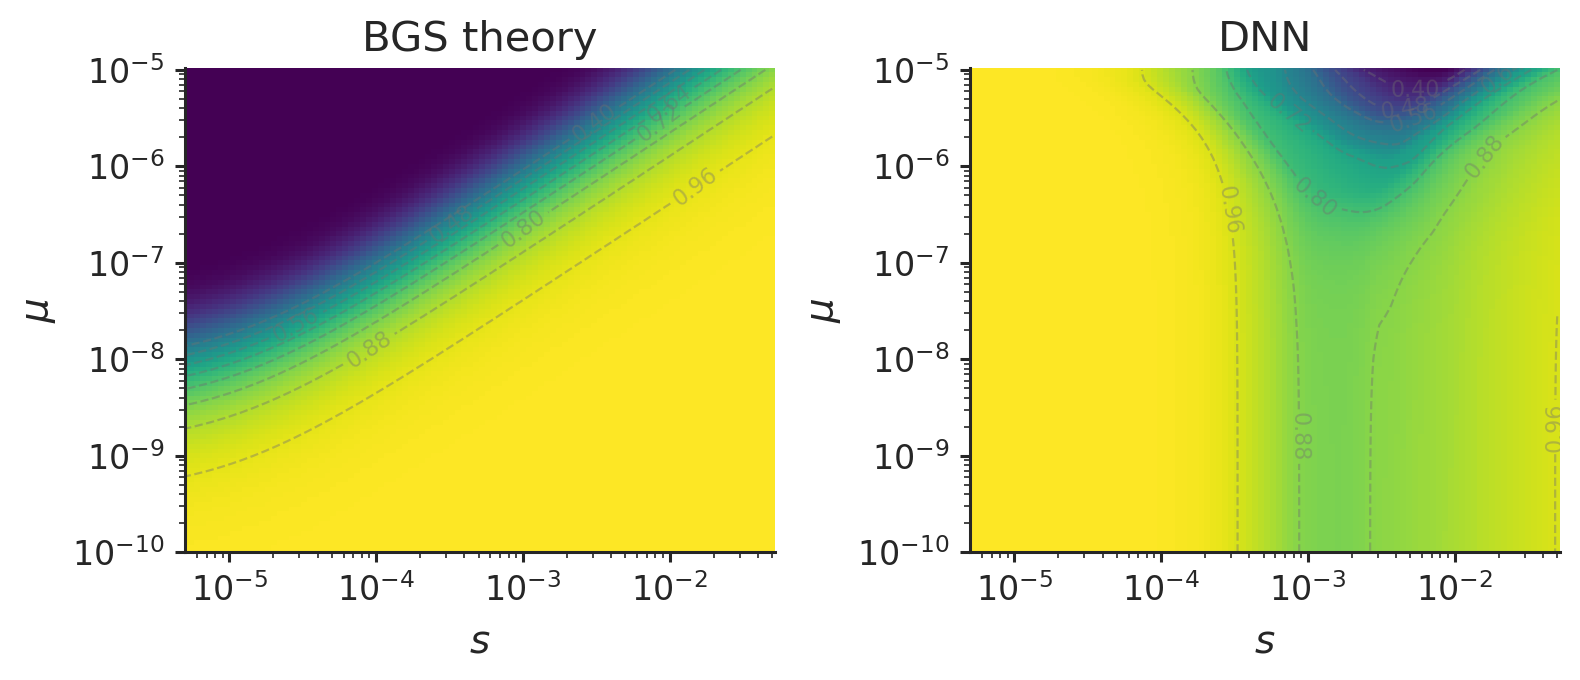

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
surface_plot(s_grid, mu_grid, Z, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

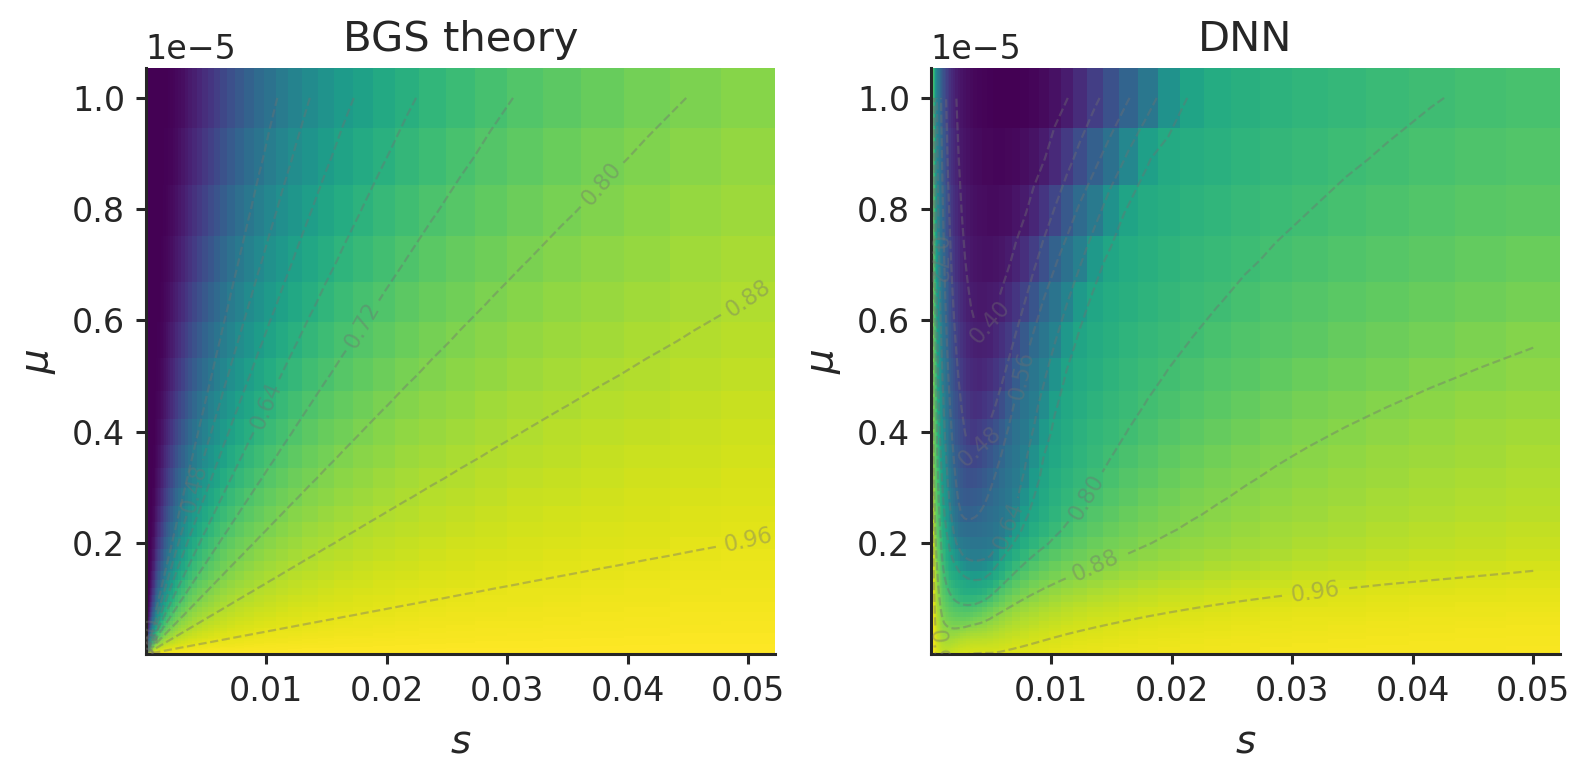

In [33]:
fig, ax = plt.subplots(ncols=2)
surface_plot(s_grid, mu_grid, Z, scale=None, ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp, scale=None, ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

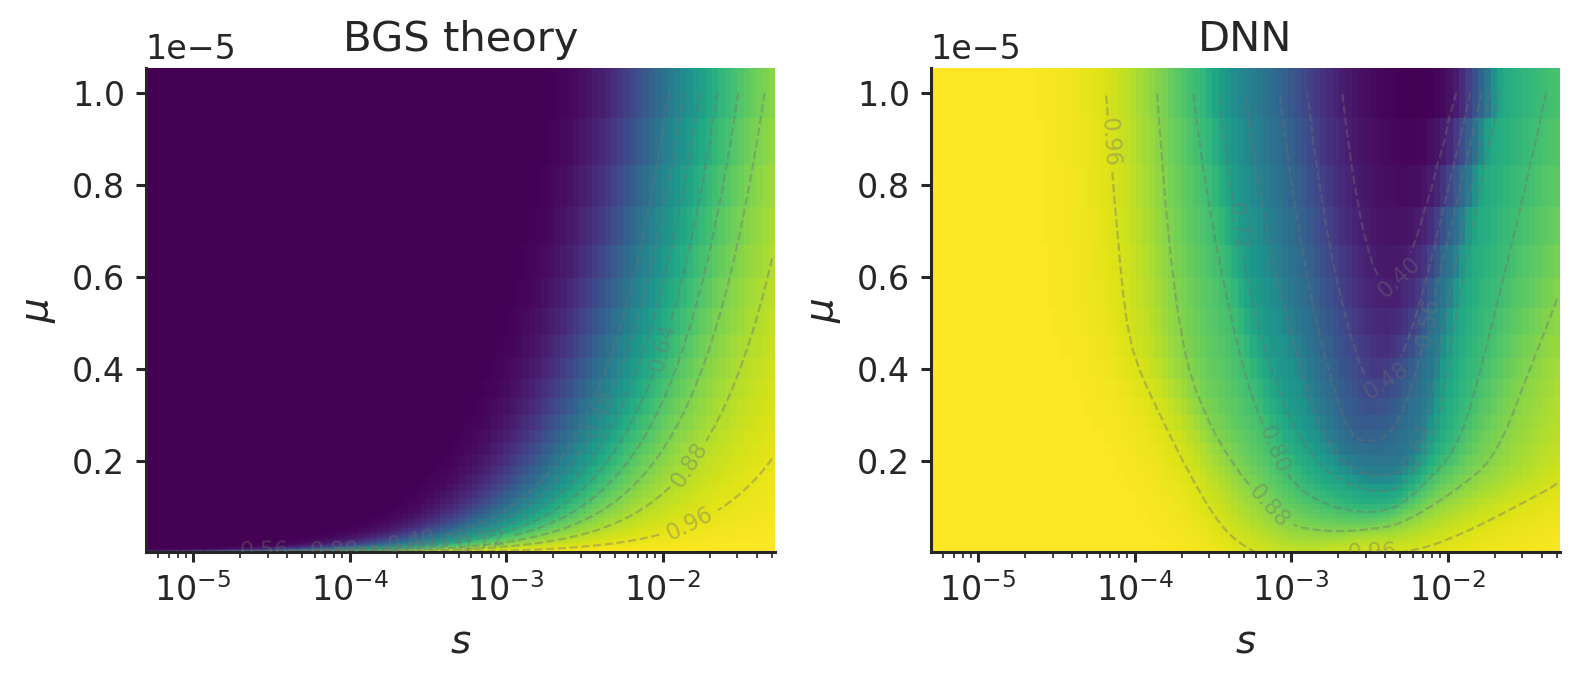

In [34]:

fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
surface_plot(s_grid, mu_grid, Z, scale='semilogx', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp, scale='semilogx', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout() 


(<Figure size 800x600 with 1 Axes>,
 <AxesSubplot:xlabel='$s$', ylabel='$\\mu$'>)

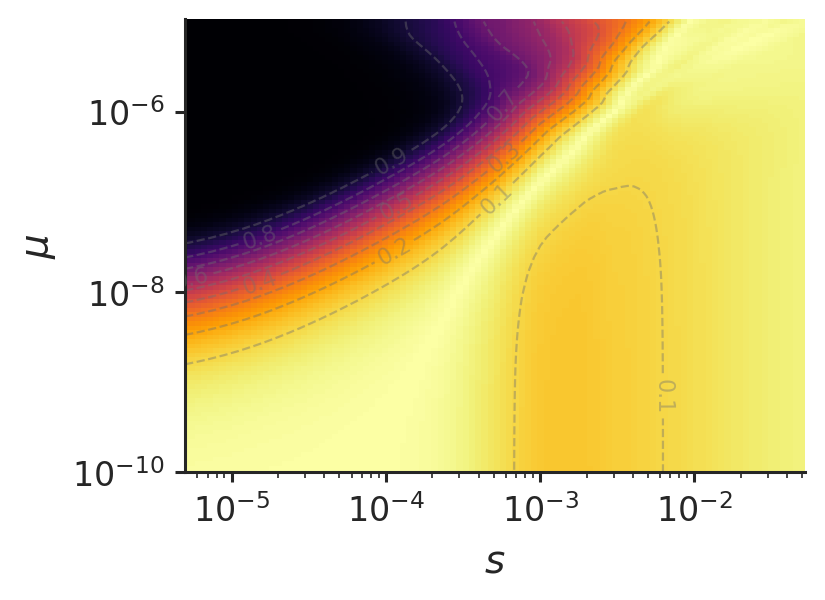

In [34]:
Zdiff = np.abs(Z-Zp)
figax = plt.subplots(figsize=(4, 3))
surface_plot(s_grid, mu_grid, Zdiff, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=10, cmap='inferno_r', figax=figax)


### Interpolation

In [ ]:
20**2 * 50**2 * 40 / 1e6

In [ ]:
# Note that the training data does not log10 mu, but here we do 
(s_grid, mu_grid, rf_grid, rbp_grid, L_grid), X_mesh_orig, X_mesh, predict_grid = func.predict_grid({'mu': 20, 'sh': 20, 'rf': 50, 'rbp': 40, 'L': 50})

In [ ]:
plt.imshow(predict_grid[:, :, 0, 10, 10])

In [36]:
# Note that the training data does not log10 mu, but here we do (otherwise the grid looks
# like chunky peanut butter).
bs = []
ys = []
for sh in np.logspace(-5, -1,  20):
    (mu_grid_rbp, s_grid_rbp, a, b, c), X_mesh_orig_rbp, X_mesh_rbp, predict_grid_rbp = func.predict_grid({'rf': 100},
                                                                            fix_X={'mu': 1e-5, 
                                                                                   'sh': np.log10(sh),
                                                                                   'rbp': 1e-8,
                                                                                    'L': 1_000},
                                                                            )
    bs.append(a)
    ys.append(predict_grid_rbp)


making 100 grid...	done.
4/4 [==============================] - 0s 2ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 2ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 2ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 2ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 g

In [57]:
plt.cm.viridis(0)

(0.267004, 0.004874, 0.329415, 1.0)

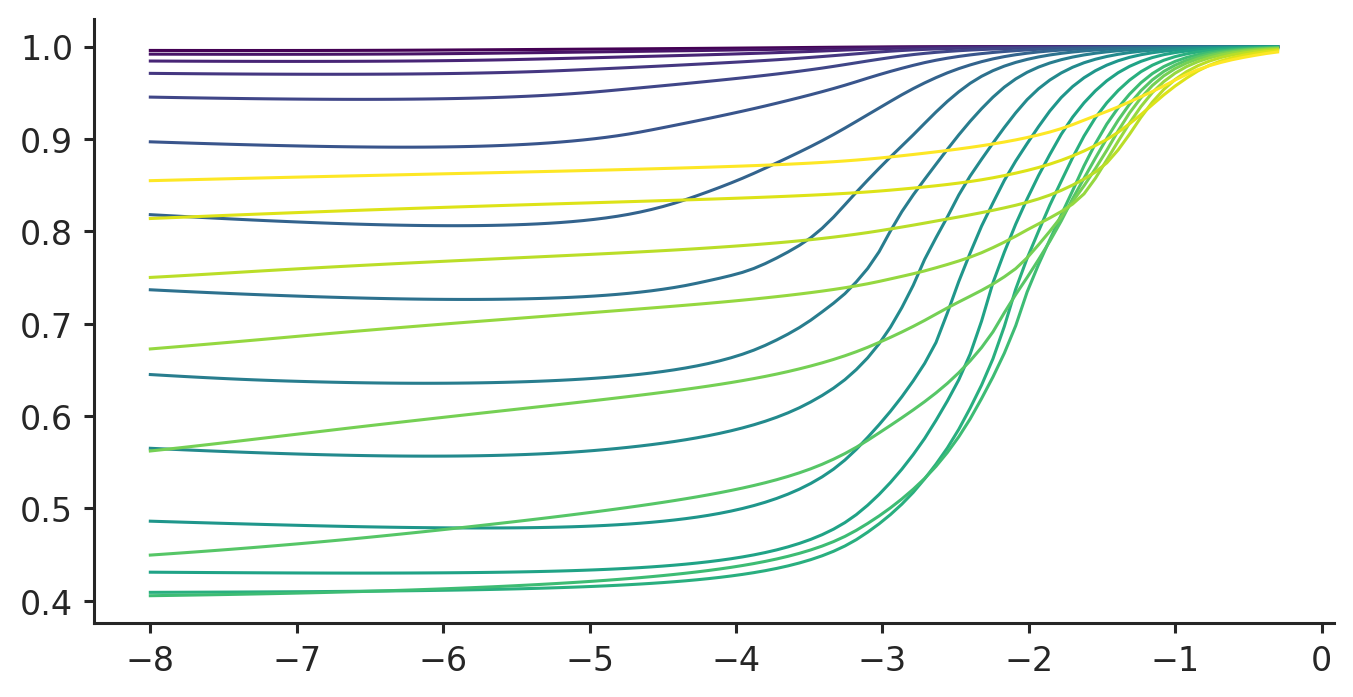

In [58]:
cmap = cm.viridis(np.linspace(0, 1, 20))
for i, y in enumerate(ys):
    plt.plot(np.log10(bs[0]), y.squeeze(), c=cmap[i])

In [62]:
from scipy.interpolate import interpn

In [63]:
(mu_grid, sh_grid, rf_grid, rbp_grid, L_grid), X_mesh_orig_rbp, X_mesh_rbp, predict_grid_rbp = func.predict_grid({'mu': 50, 'sh': 50, 'rf': 50, 'rbp': 50, 'L': 50}, log10=('sh', 'rf'))


/home/vsb/projects/bprime/notebooks/../bprime/learn.py:272: RuntimeWarning: invalid value encountered in log10
  lower = np.log10(lower)
/home/vsb/projects/bprime/notebooks/../bprime/learn.py:273: RuntimeWarning: invalid value encountered in log10
  upper = np.log10(upper)


making 50x50x50x50x50 grid...	done.


2022-04-04 19:26:10.167892: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6250000000 exceeds 10% of free system memory.
2022-04-04 19:26:25.581807: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.82GiB (rounded to 6250000128)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-04-04 19:26:25.581912: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-04-04 19:26:25.581956: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 51, Chunks in use: 50. 12.8KiB allocated for chunks. 12.5KiB in use in bin. 4.3KiB client-requested in use in bin.
2022-04-04 19:26:25.581989: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
interpnkk

In [ ]:
idx = Xo[:, 4] < 1
rate = Xo[idx, 3]/Xo[idx, 1]
yy = yo[idx, 1]
fig, ax = plt.subplots()
ax.scatter(rate, yy, alpha=0.1)

z = lowess(yy, rate, frac= 1./3, it=0)
ax.plot(z[:, 0], z[:, 1], c='r')
ax.set_xscale('log')

- make a kernel ridge vs DNN predicted surface plot
- weak impact on B can be caused by both BGS and weak selection
- is the mulitplicative right?


In [ ]:
X.shape, y.shape


In [ ]:
plt.rcParams['text.usetex'] = True

fig = plt.figure()
ax = plt.axes(projection='3d')

idx = (np.log10(X[:, 0]/X[:, 1]) > -5.3) & (np.log10(X[:, 0]/X[:, 1]) < -1.5)
Xtr = X[idx, :]
ax.scatter(np.log10(Xtr[:, 0]/Xtr[:, 1]), np.log10(Xtr[:, 2]), np.log10(y[idx]), s=2,
           c=np.log10(y[idx]), alpha=0.6, cmap='plasma')

#ax.view_init(5, 270)
ax.view_init(15, 100)
ax.set_xlim(-5, -1.5)
ax.set_xlabel('$\\mu/s$')
ax.set_ylabel('$r$')
ax.set_zlabel('$\\log_{10}(\\hat{B})$')
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_xticklabels([f'$10^{{{int(x)}}}$' for x in ax.get_xticks()])
ax.set_yticks(np.linspace(-8, -6, 3))
ax.set_yticklabels([f'$10^{{{int(x)}}}$' for x in ax.get_yticks()])
fig.savefig('/home/vsb/B3D.pdf')